# 분기고시가 예측가 산출 모델

## 변수 정의
### 1. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)
### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)
### 3. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress = True, precision = 4)
# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format
# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns", None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14
# 난수 시드
random_seed = 123
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_csv('steel_prices_data.csv', sep=',')
#날짜,분기고시가만 따로 분리
df_raw = df[['date', '분기고시가']]
#결측값 확인
df.isnull().sum()

date               105
분기고시가                0
weightA            105
priceUSA_TAIWAN    105
priceJP            105
priceCN            105
importPriceUSA     105
importPriceJP      105
stock              105
USD_KR             105
JPY_KR             105
dtype: int64

df_all.head()

In [5]:
import sys

print("--sys.version—")
print(sys.version)


--sys.version—
3.9.7 (default, Sep  3 2021, 12:45:31) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [6]:
df = df.dropna()

#날짜형으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200


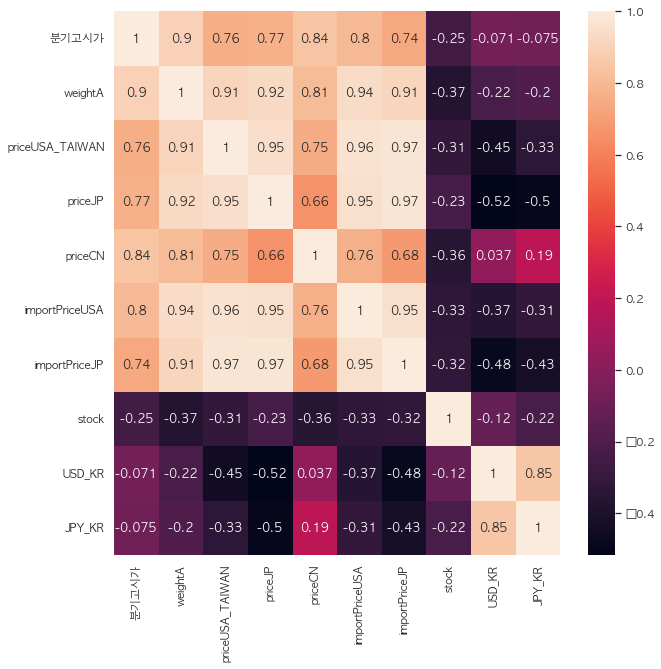

In [7]:
# 상관관계 분석  
import seaborn as sns
# 상관관계 행렬 
df_corr = df.corr()
#Drawing HEAT MAP
plt.figure (figsize=(10,10))
sns.set(font_scale=1, font="AppleGothic")
sns.heatmap(df_corr, annot=True, cbar=True);
plt.show()



In [8]:
##설명: 목표변수인 '분기고시가'열은 변수=상관 계수가, 
# 변수 weightA와 priceCN가 0.9와 0.84로 높은 편임

In [9]:
#변수 간의 상관관계 분석 - Target변수와 상관 관계까 높은 순서대로 정리
#abs()  양의  상관관계로 변환
#상관계수 값을 내림차순 정렬
df.corr()

corr_order = df.corr().loc['weightA':, '분기고시가'].sort_values(ascending=False)
corr_order 

weightA            0.8965
priceCN            0.8447
importPriceUSA     0.7994
priceJP            0.7713
priceUSA_TAIWAN    0.7607
importPriceJP      0.7427
USD_KR            -0.0712
JPY_KR            -0.0748
stock             -0.2463
Name: 분기고시가, dtype: float64

In [10]:
plot_cols= ['분기고시가', 'weightA', 'priceCN', 'importPriceUSA', 'priceJP']
plot_df = df.loc[:, plot_cols]
plot_df.head()

,분기고시가,weightA,priceCN,importPriceUSA,priceJP
0,928,546.0000,585.0000,515.0000,503.0000
1,928,535.0000,583.0000,515.0000,473.0000
2,928,528.0000,582.0000,515.0000,455.0000
3,930,527.0000,574.0000,475.0000,448.0000
4,930,535.0000,586.0000,475.0000,443.0000


### 주요 상관계수 상위 4개 변수 선형회귀선

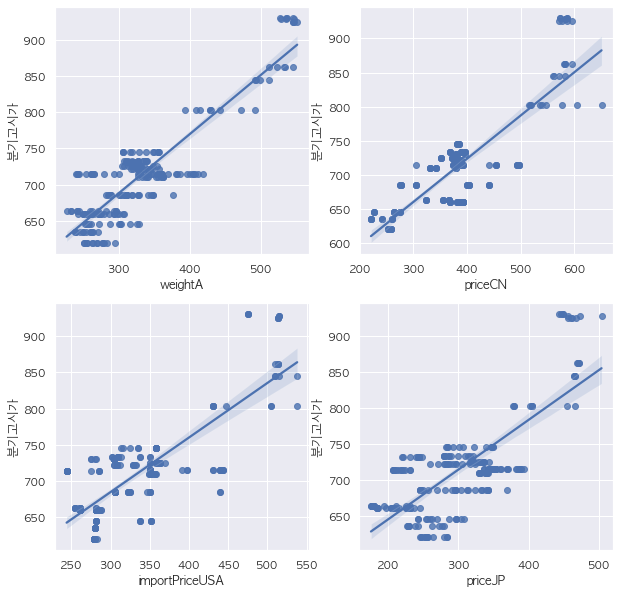

In [11]:
plt.figure(figsize = (10,10))
for idx, col in enumerate(plot_cols[1:]):
    ax1= plt.subplot(2,2,idx+1)
    sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1)
plt.show()


# 차트를 통한 타당성 확인
## 분기가 아닌 위클리로 구하기 위해, 분기내 스크랩 변동폭이 5%이상일 경우, 실시간 반영하는 '분기별 스크랩가 평균'을 기반으로 공식을 적용함.
## 스크랩가 정의: 국내스크랩(중량A)70% + 일본(H2) 20% + USA(대형-벌크) 10%

In [132]:
# 계산을 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
df['quarter'] = df['date'].dt.year+ (df.date.dt.quarter)*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000


In [136]:
display(df.tail())

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap
242,2017-02-03,620,264.0000,244.0000,253.0000,253.7000,279.0000,245.0000,1007.0000,1149.0000,1015.0100,2017.1000,261.7000
243,2017-01-27,620,270.0000,255.0000,255.0000,253.4000,279.0000,250.0000,1019.0000,1162.5000,1022.4300,2017.1000,266.9000
244,2017-01-20,620,270.0000,251.0000,256.0000,253.4000,279.0000,270.0000,944.0000,1174.0000,1021.0600,2017.1000,270.9000
245,2017-01-13,620,280.0000,251.0000,257.0000,253.4000,279.0000,280.0000,846.0000,1175.0000,1023.7900,2017.1000,279.9000
246,2017-01-06,620,295.0000,253.0000,254.0000,253.4000,283.0000,280.0000,869.0000,1193.5000,1027.2900,2017.1000,290.8000


In [137]:
#부서 고유공식(1) 적용된 스크랩가 구하기
df['scrap'] = df['weightA']*0.7 + df['importPriceJP']*0.2 + df['importPriceUSA']*0.1
df.head()

,date,분기고시가,weightA,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,quarter,scrap
0,2021-10-15,928,546.0000,473.0000,503.0000,585.0000,515.0000,535.0000,884.0000,1183.0000,1035.0400,2021.4000,540.7000
1,2021-10-08,928,535.0000,463.0000,473.0000,583.0000,515.0000,520.0000,914.0000,1190.5000,1068.5800,2021.4000,530.0000
2,2021-10-01,928,528.0000,464.0000,455.0000,582.0000,515.0000,455.0000,955.0000,1186.0000,1058.6000,2021.4000,512.1000
3,2021-09-24,930,527.0000,464.0000,448.0000,574.0000,475.0000,455.0000,938.0000,1174.0000,1068.4900,2021.3000,507.4000
4,2021-09-17,930,535.0000,455.0000,443.0000,586.0000,475.0000,455.0000,938.0000,1173.5000,1072.8200,2021.3000,513.0000


In [138]:
df_a = df.groupby(['quarter'])['분기고시가'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()
df_b.head()

,quarter,scrap
0,2017.1000,271.5769
1,2017.2000,256.0583
2,2017.3000,293.2846
3,2017.4000,326.9667
4,2018.1000,347.8077


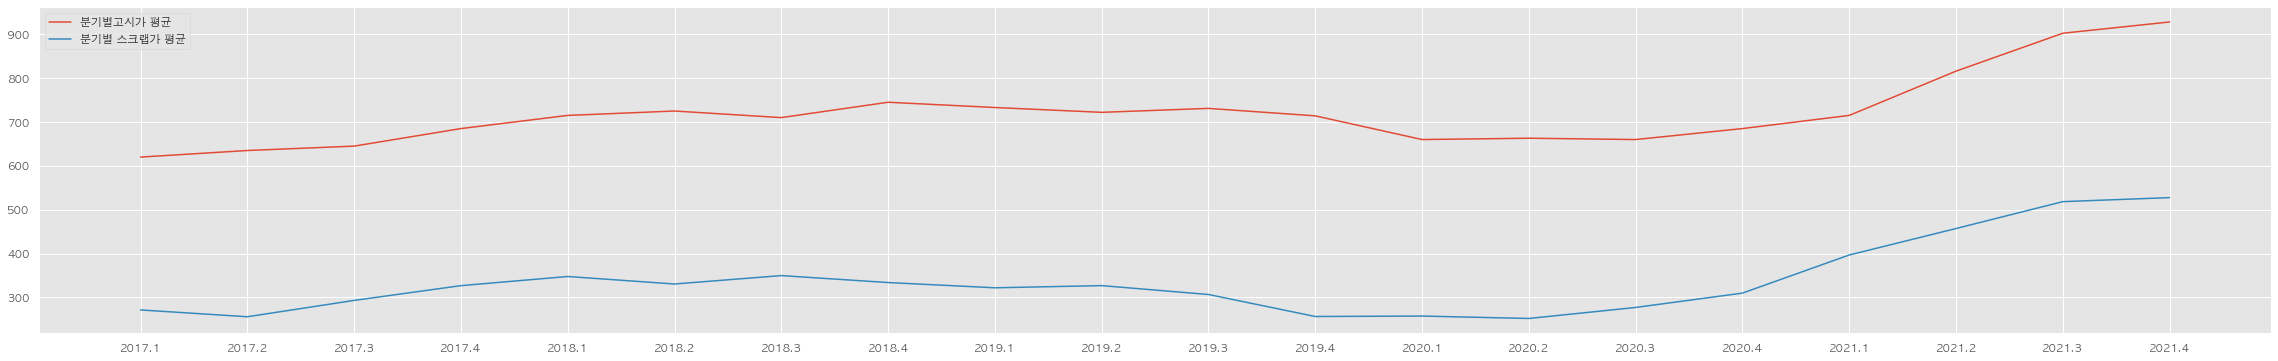

In [139]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df_a)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df_a.index, df_a['분기고시가'], label = '분기별고시가 평균')
ay.plot(df_b.index, df_b['scrap'] , label = '분기별 스크랩가 평균')
plt.xticks(xi, df_a['quarter'])
plt.legend() 

plt.show()


In [142]:
# 차트에서와 같이 이전 분기의 스크랩평균가(파란선)가 그 다음 '분기별 고시가' 평균 (빨간선)을 어느정도 앞서는 것을 확인할 수 있음

In [147]:
#분기처리를 위한 배열
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]

for m in mr:
    print(m)

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]


In [148]:
# 부서 요청사항: 스크랩평균가를 공식에 활용하여 철근의 분기(Quarter)고시가를 (Week)주기 고시가를 구하고(부서 고유공식 2), 3개월 뒤를 예측하는 모델

In [149]:
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4
print(get_quarter(3))

1


In [150]:
def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        # *9월 = (7, 8월의 스크랩평균가)의 평균가가 전분기 대비 5% +- 상관없이 변동되었을 때.
        #(같은 분기 7월) 고시가 + [(7, 8월의 스크랩평균가) - (전분기, 2분기 스크랩평균가)]
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month - 1].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month - 2].scrap.mean()
        scrap_mean = (mean1 + mean2) / 2
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year - 1
            q1 = 4
        try:
            previous_q1_mean_scrap = df_b[df_b.quarter == year + q1 * 0.1]['scrap'].values[0]
                       
            return same_quarter_price+ (scrap_mean - previous_q1_mean_scrap)
        except IndexError:
            return -1

    elif month % 3 == 1 : # 1 4 7 10
        # 7월 =전분기의 고시가인 4월 고시가 + [ 4,5,6(2분기) 스크랩 평균가  - 1분기 스크랩평균가 ] ​
        q1 = get_quarter(month) - 1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        previous_quarter_price = 0
        try:  
            previous_quarter_price  = df[df.quarter == year+0.1*(row.quarter-1)][-1:]['분기고시가'].values[0]
        except IndexError:
            previous_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month, 
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year, month, q1, q2))
            a = previous_q1_mean_scrap.values[0]
            b = previous_q2_mean_scrap.values[0]
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap) > 0 :
                return previous_quarter_price + (a - b)
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        # *8월 = 7월의 스크랩평균가가 전분기 대비 5% 변동되었을 경우,
        #(같은 분기의 7월) 고시가 + [( 7월 스크랩 평균가 ) -(전분기, 2분기 스크랩평균가) ]
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['분기고시가'].values[0]
        q1 = get_quarter(month)-1        
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        if len( previous_q1_mean_scrap.values) > 0:
            return same_quarter_price + (mean1 - previous_q1_mean_scrap.values)[0]
        else:
            return 0
df['scrap_gap'] = df['date'].apply(get_sgap)

2021-10 ( 3 2 )
2021-10 ( 3 2 )
2021-10 ( 3 2 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
2021-7 ( 2 1 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
4
2020-4 ( 1 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-1 ( 3 4 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 

In [151]:
925.9013*0.05

46.295065

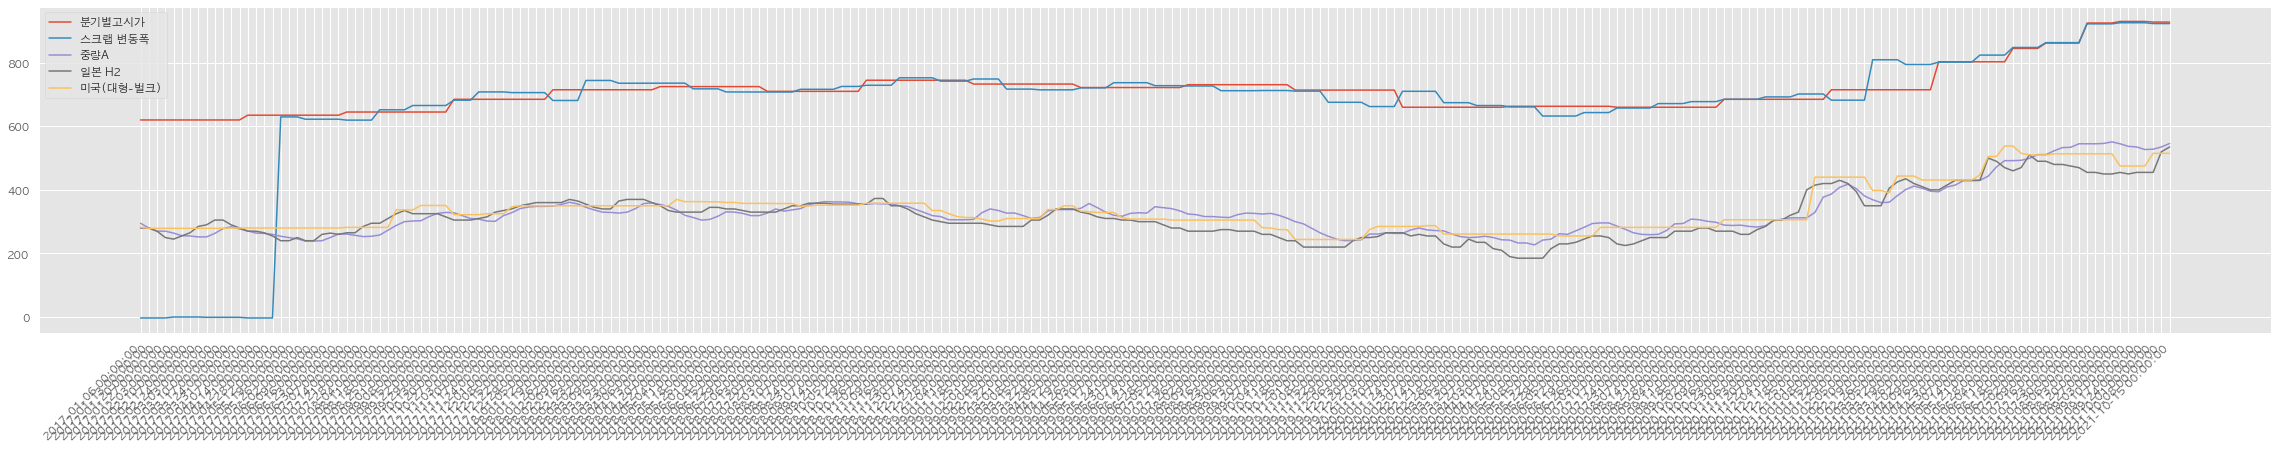

In [152]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()


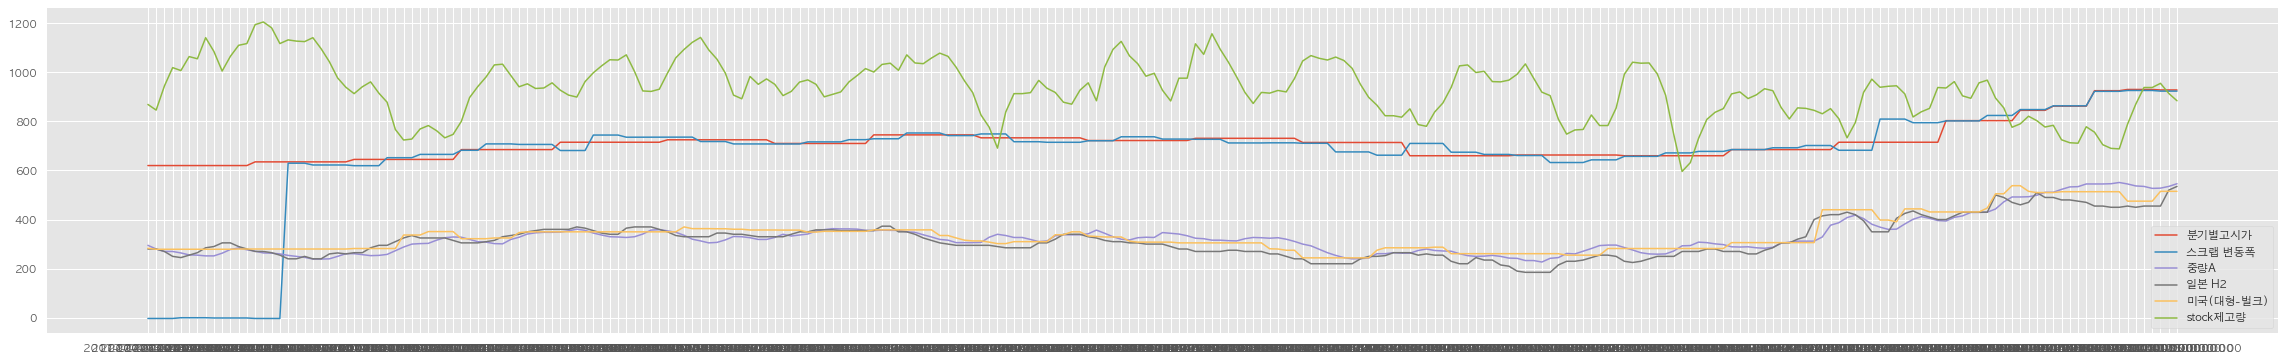

In [153]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['stock'], label = "stock제고량")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()


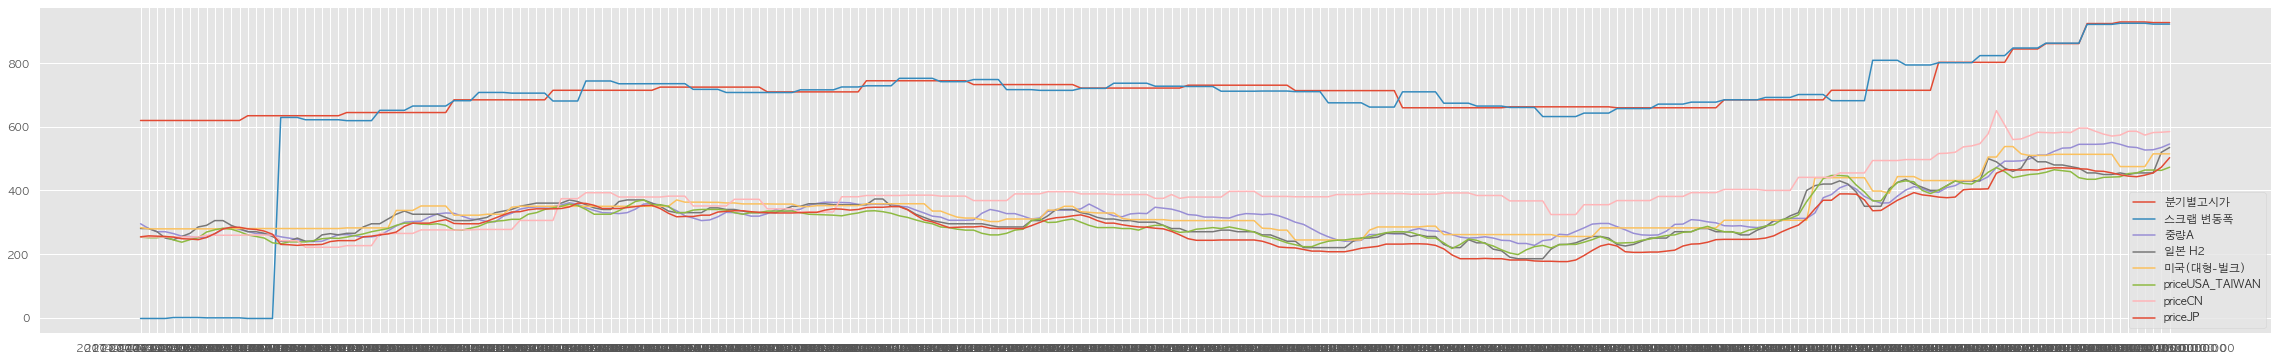

In [154]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['분기고시가'], label = '분기별고시가')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
ay.plot(df.index, df['importPriceJP'], label='일본 H2')
ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

ay.plot(df.index, df['priceUSA_TAIWAN'], label = "priceUSA_TAIWAN")
ay.plot(df.index, df['priceCN'], label = "priceCN")
ay.plot(df.index, df['priceJP'], label = "priceJP")

plt.xticks(xi, df['date'])
plt.legend()

ay.invert_xaxis()
#ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

In [1]:
from prophet import Prophet
import pandas as pd

Importing plotly failed. Interactive plots will not work.


In [3]:
# df['stock'] 국내 철강사 제고량이 시계열 특성을 가지고 있으므로 prophet으로 시황성 자제 제고를 예측
df_for_p = pd.DataFrame()
df_for_p['ds'] = df['date']
df_for_p['y'] = df['분기고시가']
print(df_for_p)

# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(df_for_p)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=10, freq='w')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data ,  figsize=(15, 10)) 

NameError: name 'pd' is not defined